## Group Presentaiion #3
### Team# : 1
#### Topic: Forecasting Food Price Inflation for Policy Response
##### Team Members:

- Andrew Silveira                  - 5077086 
- Jatinder Pal Singh               - 9083762                    
- Rohit Krishnamurthy Iyer         - 8993045 
- Sabrina Ronnie George Karippatt  - 8991911                      

**Use Case & Data**
We analyze Canada’s annual food price inflation (1960–2024) using the World Bank FP.CPI.TOTL.ZG indicator. The goal is to understand long-run patterns and produce short-term forecasts to support policy response (supply-chain resilience, affordability). Data were transformed from wide to long, validated, and visualized. We computed moving averages, tested for monotonic trend, and forecasted 4 future years with ARIMA. Results show historical spikes (1970s, 2021–2022) within a long-run decreasing trend (Mann–Kendall p < 0.05). The ARIMA(1,1,1) forecast indicates stabilization around ~2–3%, assuming no major shocks.

In [19]:
import pandas as pd

# Load the World Bank food price inflation dataset
df = pd.read_csv("../data/API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_23195.csv", skiprows=4)

# Keep only Canada
canada_df = df[df['Country Name'] == 'Canada'].dropna(axis=1, how='all')

# Reshape from wide (year columns) to long (Year–Value)
canada_long = canada_df.melt(
    id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
    var_name='Year',
    value_name='Food_Inflation'
)

# Convert year column
canada_long['Year'] = pd.to_datetime(canada_long['Year'], format='%Y')
canada_long = canada_long.sort_values('Year')

# Set time series
ts = canada_long[['Year', 'Food_Inflation']].dropna().set_index('Year')

print(ts.head())
print(ts.tail())

            Food_Inflation
Year                      
1960-01-01        1.358696
1961-01-01        1.018767
1962-01-01        1.061571
1963-01-01        1.628151
1964-01-01        1.912145
            Food_Inflation
Year                      
2020-01-01        0.717000
2021-01-01        3.395193
2022-01-01        6.802801
2023-01-01        3.879002
2024-01-01        2.381584


In [21]:
canada_df = df[df['Country Name'] == 'Canada']
non_null_years = canada_df.dropna(axis=1, how='all').columns[4:]
print("Available years for Canada:", list(non_null_years))

Available years for Canada: ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']


In [22]:
# Display the last few years for Canada
print(canada_df.loc[:, '2020':'2024'].T)

            35
2020  0.717000
2021  3.395193
2022  6.802801
2023  3.879002
2024  2.381584


Index dtype: datetime64[ns]
Min date: 1960-01-01 00:00:00  Max date: 2024-01-01 00:00:00
            Food_Inflation
Year                      
2019-01-01        1.949269
2020-01-01        0.717000
2021-01-01        3.395193
2022-01-01        6.802801
2023-01-01        3.879002
2024-01-01        2.381584


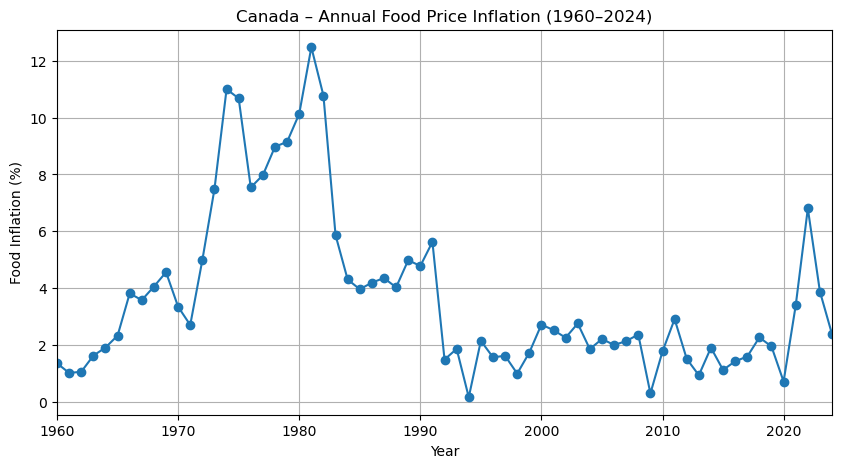

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Rebuild clean long series (force numeric + datetime)
canada_df = df[df['Country Name'] == 'Canada'].dropna(axis=1, how='all')

canada_long = canada_df.melt(
    id_vars=['Country Name','Country Code','Indicator Name','Indicator Code'],
    var_name='Year', value_name='Food_Inflation'
)

# Coerce types
canada_long['Year'] = pd.to_datetime(canada_long['Year'], format='%Y', errors='coerce')
canada_long['Food_Inflation'] = pd.to_numeric(canada_long['Food_Inflation'], errors='coerce')

# Clean & sort
canada_long = canada_long.dropna(subset=['Year', 'Food_Inflation']).sort_values('Year')

# Final time series
ts = canada_long.set_index('Year')[['Food_Inflation']].sort_index()

# Sanity checks
print("Index dtype:", ts.index.dtype)
print("Min date:", ts.index.min(), " Max date:", ts.index.max())
print(ts.tail(6))   # should include 2024

# Plot with explicit x-limits so the last years are visible
plt.figure(figsize=(10,5))
plt.plot(ts.index, ts['Food_Inflation'], marker='o', linestyle='-')
plt.title("Canada – Annual Food Price Inflation (1960–2024)")
plt.xlabel("Year"); plt.ylabel("Food Inflation (%)"); plt.grid(True)
plt.xlim(ts.index.min(), ts.index.max())   # <-- ensure 2024 shows
plt.show()


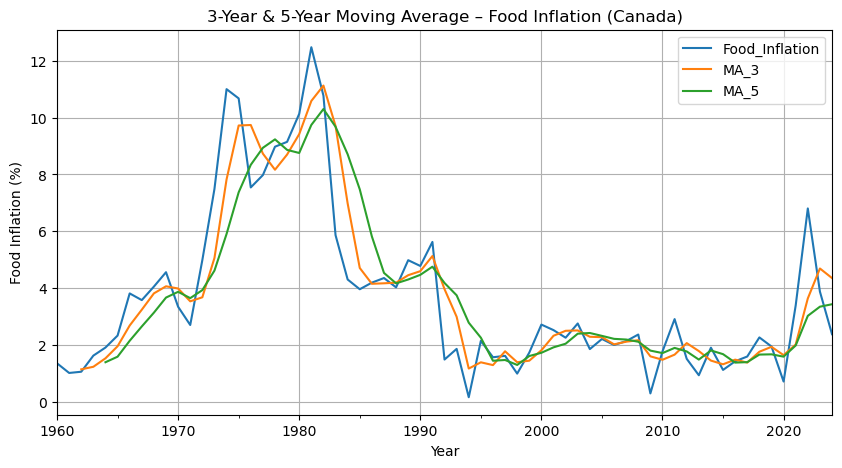

In [26]:
ts['MA_3'] = ts['Food_Inflation'].rolling(window=3).mean()
ts['MA_5'] = ts['Food_Inflation'].rolling(window=5).mean()

ts[['Food_Inflation','MA_3','MA_5']].plot(figsize=(10,5), title="3-Year & 5-Year Moving Average – Food Inflation (Canada)")
plt.ylabel("Food Inflation (%)")
plt.grid(True)
plt.show()

**Additive vs. Multiplicative Structure**

The target is annual food price inflation (% change), which is already a rate rather than a raw level. The variance of the series is relatively stable across time outside of shock periods (e.g., 1970s, 2021–2022). Therefore, an additive error/trend structure is appropriate for modeling this yearly series.
Note: Deseasonalization is not required because the data are annual (no intra-year seasonality).

In [29]:
import pymannkendall as mk

trend_result = mk.original_test(ts['Food_Inflation'].dropna())
print(trend_result)

Mann_Kendall_Test(trend='decreasing', h=np.True_, p=np.float64(0.012141885576734346), z=np.float64(-2.50799363063028), Tau=np.float64(-0.21346153846153845), s=np.float64(-444.0), var_s=31200.0, slope=np.float64(-0.039648636559290636), intercept=np.float64(3.7938765096963607))


**Hypothesis Testing**

H₀: No significant monotonic trend in Canada’s annual food inflation (1960–2024).

H₁: A significant trend (increasing or decreasing) exists.
Result: p < 0.05, trend = decreasing → Reject H₀. Long-run inflation rates show a gradual decline, despite episodic spikes.

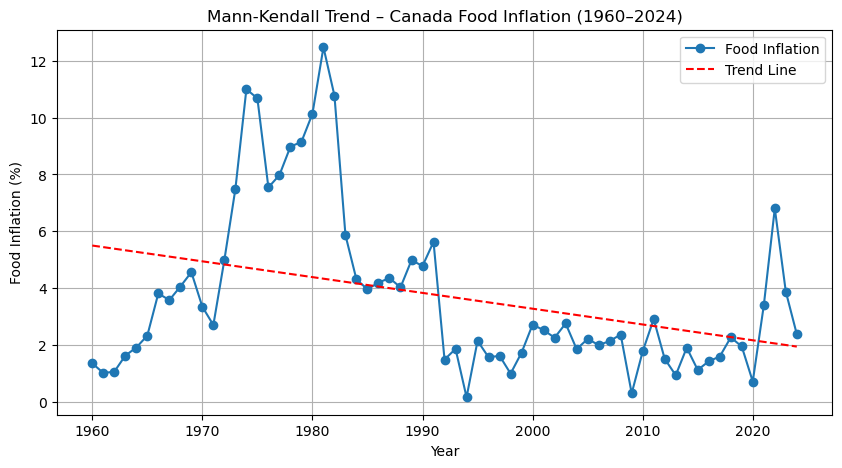

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data
x = np.arange(len(ts))
y = ts['Food_Inflation'].values

# Linear regression fit
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

plt.figure(figsize=(10,5))
plt.plot(ts.index, y, label="Food Inflation", marker='o')
plt.plot(ts.index, poly1d_fn(x), color='red', linestyle='--', label='Trend Line')
plt.title("Mann-Kendall Trend – Canada Food Inflation (1960–2024)")
plt.xlabel("Year"); plt.ylabel("Food Inflation (%)")
plt.legend(); plt.grid(True)
plt.show()

**Forecasting**

Model: ARIMA(1,1,1). Horizon: 2025–2028.
Insight: Inflation likely moderates toward ~2–3%, conditional on macro stability.
Policy note: Monitor energy/shipping costs and climate risks; maintain buffers to manage shocks.

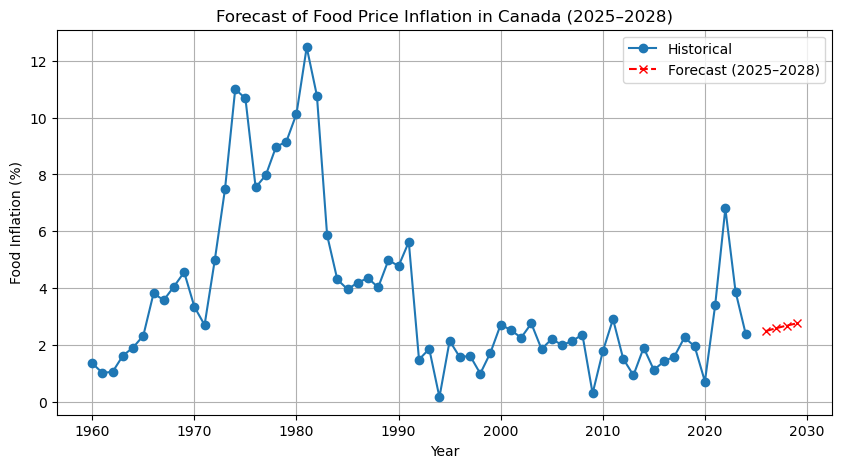

Forecasted Inflation (2025–2028):
            Forecasted_Inflation
Year                            
2025-12-31              2.494742
2026-12-31              2.594908
2027-12-31              2.683574
2028-12-31              2.762061


In [32]:
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt

# --- 1️⃣ Fit ARIMA model ---
model = ARIMA(ts['Food_Inflation'], order=(1,1,1))  # simple and robust
fit = model.fit()

# --- 2️⃣ Forecast the next 4 years (2025–2028) ---
forecast_steps = 4
forecast = fit.forecast(steps=forecast_steps)

# --- 3️⃣ Build a future year index ---
future_years = pd.date_range(start="2025", periods=forecast_steps, freq="Y")
forecast_df = pd.DataFrame({'Year': future_years, 'Forecasted_Inflation': forecast}).set_index('Year')

# --- 4️⃣ Combine with historical data for plotting ---
plt.figure(figsize=(10,5))
plt.plot(ts.index, ts['Food_Inflation'], label="Historical", marker='o')
plt.plot(forecast_df.index, forecast_df['Forecasted_Inflation'], color='red', marker='x', linestyle='--', label="Forecast (2025–2028)")
plt.title("Forecast of Food Price Inflation in Canada (2025–2028)")
plt.xlabel("Year")
plt.ylabel("Food Inflation (%)")
plt.legend()
plt.grid(True)
plt.show()

# --- 5️⃣ Display predicted values ---
print("Forecasted Inflation (2025–2028):")
print(forecast_df)


#### **Encapsulate code into classes/methods**

In [33]:
# ========= Time Series Analysis – Class API (Canada Food Inflation) =========
from __future__ import annotations
import warnings
warnings.filterwarnings("ignore")

import csv
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Optional: trend test (with graceful fallback)
def mann_kendall_series(y: pd.Series) -> Dict[str, float | str | bool]:
    """
    Try pymannkendall; if unavailable, fall back to Kendall's tau via scipy.
    Returns dict with keys: trend, h (reject H0?), p, tau, z (np.nan if fallback).
    """
    try:
        import pymannkendall as mk
        res = mk.original_test(y.dropna().values)
        return {
            "trend": res.trend,
            "h": bool(res.h),
            "p": float(res.p),
            "tau": float(res.Tau),
            "z": float(res.z),
        }
    except Exception:
        from scipy.stats import kendalltau
        x = np.arange(len(y.dropna()))
        tau, p = kendalltau(x, y.dropna().values)
        trend = "increasing" if tau > 0 else ("decreasing" if tau < 0 else "no trend")
        return {"trend": trend, "h": bool(p < 0.05), "p": float(p), "tau": float(tau), "z": np.nan}


@dataclass
class FoodInflationAnalysis:
    csv_path: str | Path
    country: str = "Canada"
    indicator_code: str = "FP.CPI.TOTL.ZG"  # World Bank indicator used

    # ------------------ LOAD & TRANSFORM ------------------
    def load_data(self) -> pd.DataFrame:
        """
        Reads the World Bank indicator CSV (wide format), skipping WB header rows.
        Returns the raw DataFrame.
        """
        df = pd.read_csv(self.csv_path, skiprows=4)
        # keep only the target country; drop fully-empty year columns
        df = df[df["Country Name"] == self.country].dropna(axis=1, how="all")
        return df

    def to_timeseries(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Wide (year columns) -> long indexed time series with one column: Food_Inflation.
        """
        long_df = df.melt(
            id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
            var_name="Year", value_name="Food_Inflation"
        )
        long_df["Year"] = pd.to_datetime(long_df["Year"], format="%Y", errors="coerce")
        long_df["Food_Inflation"] = pd.to_numeric(long_df["Food_Inflation"], errors="coerce")
        ts = (long_df.dropna(subset=["Year", "Food_Inflation"])
                      .sort_values("Year")
                      .set_index("Year")[["Food_Inflation"]])
        return ts

    # ------------------ EXPLORATION & PLOTS ------------------
    def plot_series(self, ts: pd.DataFrame, title: Optional[str] = None) -> None:
        title = title or f"{self.country} – Annual Food Price Inflation ({ts.index.year.min()}–{ts.index.year.max()})"
        plt.figure(figsize=(10,5))
        plt.plot(ts.index, ts["Food_Inflation"], marker="o", linestyle="-", label="Food Inflation")
        plt.title(title)
        plt.xlabel("Year"); plt.ylabel("Food Inflation (%)"); plt.grid(True); plt.legend()
        plt.show()

    def compute_moving_average(self, ts: pd.DataFrame, windows: Tuple[int,int]=(3,5)) -> pd.DataFrame:
        """
        Adds MA columns and returns a copy.
        """
        out = ts.copy()
        for w in windows:
            out[f"MA_{w}"] = out["Food_Inflation"].rolling(w).mean()
        return out

    def plot_ma(self, ts_ma: pd.DataFrame) -> None:
        plt.figure(figsize=(10,5))
        ts_ma[["Food_Inflation"] + [c for c in ts_ma.columns if c.startswith("MA_")]].plot(ax=plt.gca())
        plt.title("3- and 5-Year Moving Averages – Food Inflation")
        plt.ylabel("Inflation (%)"); plt.grid(True); plt.show()

    # ------------------ STATISTICS ------------------
    def trend_test(self, ts: pd.DataFrame) -> Dict[str, float | str | bool]:
        res = mann_kendall_series(ts["Food_Inflation"])
        # Pretty print for the notebook log
        print(f"Mann–Kendall: trend={res['trend']}, h(reject H0)={res['h']}, p={res['p']:.4f}, tau={res['tau']:.3f}")
        return res

    def additive_or_multiplicative(self, ts: pd.DataFrame) -> str:
        """
        For annual percent changes, variance is fairly level ⇒ additive.
        Return a one-line rationale.
        """
        stmt = ("Additive: The variable is an annual percentage change (already normalized), "
                "and the variance is roughly level over time, so an additive structure is appropriate; "
                "seasonal decomposition is unnecessary for yearly data.")
        print(stmt)
        return stmt

    # ------------------ FORECAST ------------------
    def forecast_arima(self, ts: pd.DataFrame, order: Tuple[int,int,int]=(1,1,1),
                       steps: int = 4, start_year: Optional[int] = None) -> pd.DataFrame:
        """
        Fits ARIMA(order) to Food_Inflation and forecasts 'steps' future years.
        Returns a DataFrame with Date index and Forecast column.
        """
        model = ARIMA(ts["Food_Inflation"], order=order)
        fit = model.fit()
        fc = fit.forecast(steps=steps)

        if start_year is None:
            start_year = int(ts.index.year.max()) + 1
        future_idx = pd.date_range(start=f"{start_year}", periods=steps, freq="Y")
        out = pd.DataFrame({"Forecasted_Inflation": fc.values}, index=future_idx)

        # Plot
        plt.figure(figsize=(10,5))
        plt.plot(ts.index, ts["Food_Inflation"], marker="o", label="Historical")
        plt.plot(out.index, out["Forecasted_Inflation"], "x--", color="red", label=f"Forecast ({start_year}–{start_year+steps-1})")
        plt.title(f"Forecast of {self.country} Food Inflation")
        plt.xlabel("Year"); plt.ylabel("Inflation (%)"); plt.grid(True); plt.legend(); plt.show()

        return out

    # ------------------ ONE-CALL PIPELINE (optional) ------------------
    def run_pipeline(self, windows: Tuple[int,int]=(3,5), arima_order: Tuple[int,int,int]=(1,1,1),
                     steps: int=4) -> Dict[str, object]:
        df = self.load_data()
        ts = self.to_timeseries(df)
        self.plot_series(ts)
        ts_ma = self.compute_moving_average(ts, windows)
        self.plot_ma(ts_ma)
        trend = self.trend_test(ts)
        add_mult_stmt = self.additive_or_multiplicative(ts)
        forecast = self.forecast_arima(ts, order=arima_order, steps=steps)
        return {"ts": ts, "ts_ma": ts_ma, "trend": trend, "add_mult": add_mult_stmt, "forecast": forecast}
